# Facebook Prophet

In [4]:
import pandas as pd

In [10]:
springfield = pd.read_csv('data/springfield.csv')
springfield['date'] = pd.to_datetime(springfield['date'])
springfield.rename(columns={'date':'ds'}, inplace=True)
springfield

,ds,65807,65802,65804,65810,65806,65809
0,1996-04-01,80800.0,64800.0,83200.0,117900.0,38800.0,158200.0
1,1996-05-01,80800.0,64100.0,83200.0,116800.0,38500.0,158000.0
2,1996-06-01,80900.0,63500.0,83300.0,115900.0,38200.0,158000.0
3,1996-07-01,81100.0,63000.0,83500.0,115200.0,38000.0,158100.0
4,1996-08-01,81400.0,62600.0,83700.0,114800.0,37600.0,158300.0
...,...,...,...,...,...,...,...
260,2017-12-01,119900.0,94800.0,141800.0,192000.0,61000.0,257400.0
261,2018-01-01,120500.0,95400.0,141800.0,192900.0,61600.0,257500.0
262,2018-02-01,121400.0,95900.0,142800.0,195000.0,61700.0,260400.0
263,2018-03-01,122800.0,96600.0,145100.0,198000.0,62000.0,266200.0


## Baseline

In [ ]:
from fbprophet import Prophet
import matplotlib.pyplot as plt
plt.style.use('seaborn')
plt.style.use('seaborn-talk')
import warnings
warnings.filterwarnings('ignore')

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

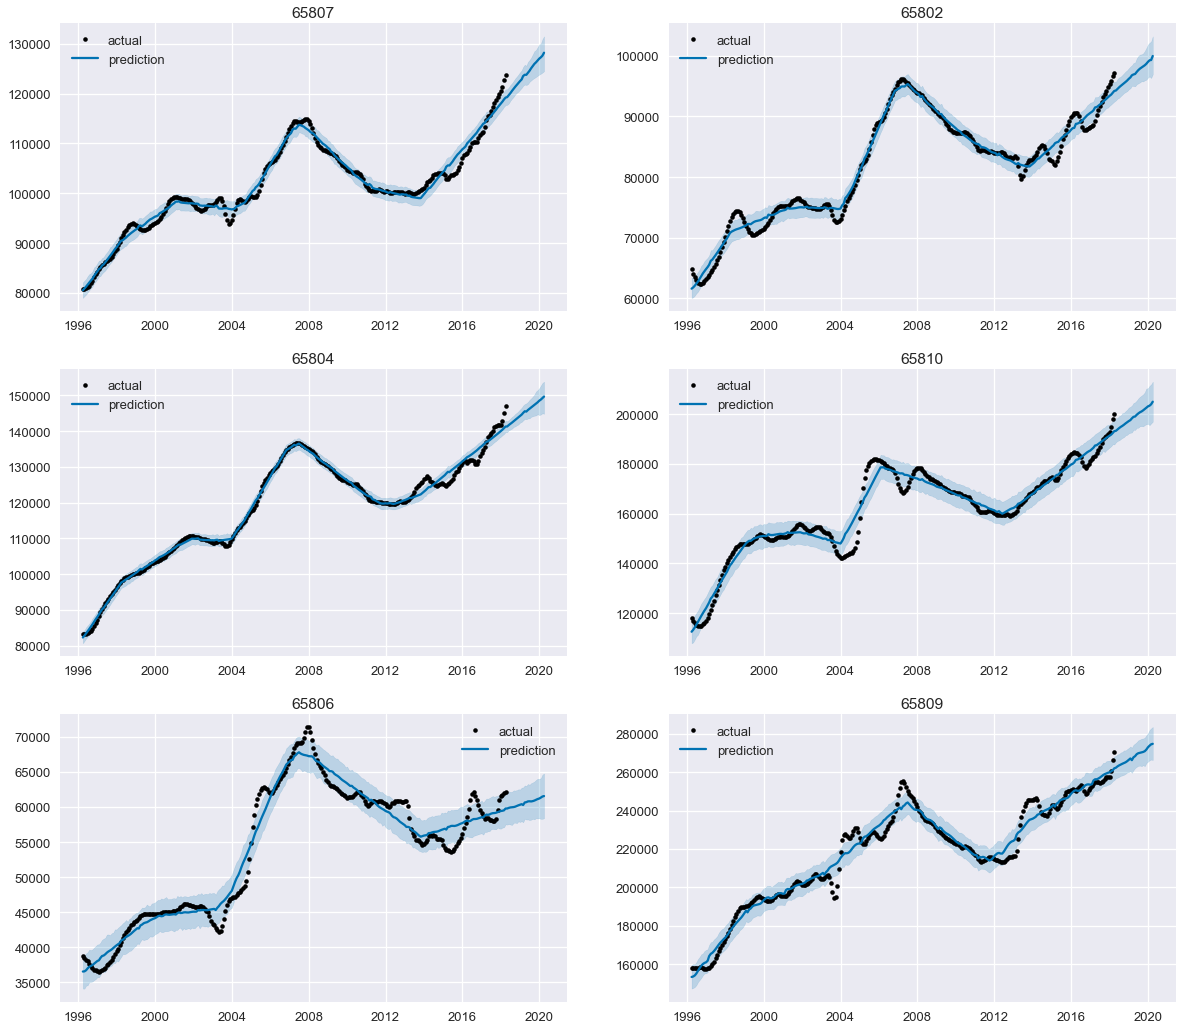

In [29]:
fig = plt.figure(figsize=(20, 18))
axs = fig.subplots(3, 2).flatten()

for i, col in enumerate(springfield.columns[1:]):
    ts = springfield[['ds', col]].rename(columns={col:'y'})
    ts_model = Prophet()
    ts_model.fit(ts)
    forecast = ts_model.predict(ts_model.make_future_dataframe(periods=24, freq='MS'))
    
    ax = axs[i]
    ax.plot('ds', col, 'k.', data=springfield)
    ax.plot(forecast['ds'], forecast['yhat'], ls='-', c='#0072B2')
    ax.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='#0072B2', alpha=0.2)
    ax.set_title(col)
    ax.legend(labels=('actual', 'prediction'))

plt.show()

In [16]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,1996-04-01,153107.182446,147290.681539,159442.008358,153107.182446,153107.182446,364.546539,364.546539,364.546539,364.546539,364.546539,364.546539,0.0,0.0,0.0,153471.728985
1,1996-05-01,154123.015960,147599.603951,159430.658298,154123.015960,154123.015960,-418.329793,-418.329793,-418.329793,-418.329793,-418.329793,-418.329793,0.0,0.0,0.0,153704.686167
2,1996-06-01,155172.710592,148487.024591,160758.977367,155172.710592,155172.710592,-907.278627,-907.278627,-907.278627,-907.278627,-907.278627,-907.278627,0.0,0.0,0.0,154265.431965
3,1996-07-01,156188.544107,149476.074676,161331.469983,156188.544107,156188.544107,-909.781665,-909.781665,-909.781665,-909.781665,-909.781665,-909.781665,0.0,0.0,0.0,155278.762442
4,1996-08-01,157238.238738,150490.200531,162736.438276,157238.238738,157238.238738,-509.219690,-509.219690,-509.219690,-509.219690,-509.219690,-509.219690,0.0,0.0,0.0,156729.019048
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284,2019-12-01,272312.158203,263989.744072,279420.014207,268164.070694,276775.439204,-625.015845,-625.015845,-625.015845,-625.015845,-625.015845,-625.015845,0.0,0.0,0.0,271687.142359
285,2020-01-01,272824.420083,265009.270974,281072.223051,268244.858776,277841.142462,66.462371,66.462371,66.462371,66.462371,66.462371,66.462371,0.0,0.0,0.0,272890.882455
286,2020-02-01,273336.681963,265558.748442,281966.121947,268459.065763,278623.040689,396.676739,396.676739,396.676739,396.676739,396.676739,396.676739,0.0,0.0,0.0,273733.358703
287,2020-03-01,273815.894690,265763.874305,283352.890390,268567.598891,279310.397368,609.958916,609.958916,609.958916,609.958916,609.958916,609.958916,0.0,0.0,0.0,274425.853606


## Hyperparameter Tuning

In [ ]:
import itertools
from fbprophet.diagnostics import cross_validation, performance_metrics

In [ ]:
param_grid = {  
    'changepoint_prior_scale': [0.005, 0.05, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
    'holidays_prior_scale': [0.01, 0.1, 1.0, 10.0],
    'seasonality_mode': ['additive', 'multiplicative']
}

In [ ]:
ts = sf_train[['ds', '65807']].rename(columns={'65807':'y'})

param_grid = {  
    'changepoint_prior_scale': [0.005, 0.05, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
    'holidays_prior_scale': [0.01, 0.1, 1.0, 10.0],
    'seasonality_mode': ['additive', 'multiplicative']
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params).fit(ts)  # Fit model with given params
    df_cv = cross_validation(m, initial='16 y', period='120 days', horizon = '1 y')
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
tuning_results

In [ ]:
tuning_results.sort_values('rmse')

In [ ]:
rmses